# train SOM for the CEM dataset

check how well a geometric encoding can represent the geometric forms

- June 6 2022, using autoencoder seems not to be a good idea as similar latent vector does not result in similar forms
- worth to check: fisher vector

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json

In [2]:
import cem_mini
from cem_mini import plot_cem_form
import dataset
import sompy
import som_util
import logging
logging.root.setLevel(logging.ERROR)

## load the dataset

In [3]:
cem_dataset=dataset.get_dataset_from_file(r'..\cem-dataset\cem-towers\SDML_CEM.py')

In [5]:
import math

def _check_form(form,ax,view, vrange=None):
    plot_cem_form(ax,form['coords'],form['edges'],form['forces'],view=view,thickness_base=0.5,thickness_ratio=0.02,vrange=vrange)

def check_forms(forms,axis='off',view='3D-45',vrange=None, fname=None):
    if type(forms) is list:
        rows = int(len(forms)**0.5)
        cols = int(math.ceil(len(forms) / rows))
        
        fig=plt.figure(figsize=(16,int(16/cols*rows)))
        for i in range(len(forms)):
            ax=fig.add_subplot(rows, cols, i+1, projection='3d')
            _check_form(forms[i],ax,view, vrange)
            plt.axis(axis)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    elif type(forms) is dict:
        plt.figure(figsize=(8,8))
        ax=plt.axes(projection='3d')
        _check_form(forms,ax,view, vrange)
        plt.axis(axis)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()

check the dataset

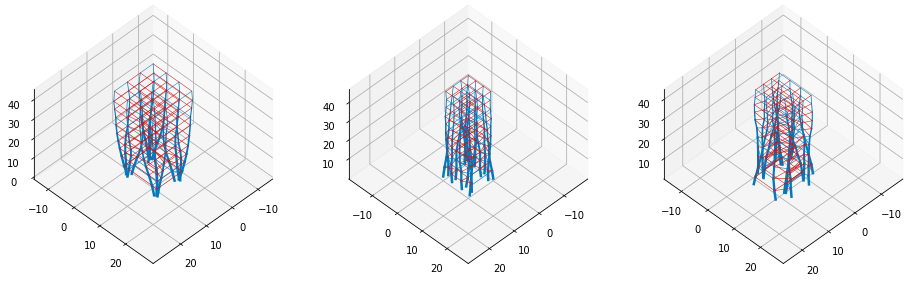

In [6]:
check_forms(cem_dataset.get_forms(range(3)),'on')

In [6]:
cem_dataset.get_feature_names()

['num_floors',
 'num_nodes',
 'num_trail_edges',
 'num_dev_edges',
 'grid_size_x',
 'grid_size_y',
 'load_x',
 'load_y',
 'load_z',
 'total_lp',
 'floor_heights',
 'node_x',
 'node_y',
 'node_z',
 'trail_length',
 'trail_mag',
 'dev_length',
 'dev_mag']

### for IASS presentation
show each trail path

In [7]:
def _check_form_by_edge_mask(form, mask, ax, view, vrange=None):
    forces = np.copy(form['forces'])
    
    for i in range(len(mask)):
        if not mask[i]:
            forces[i] = np.nan
    
    plot_cem_form(ax,form['coords'],form['edges'],forces,view=view,thickness_base=0.5,thickness_ratio=0.02,vrange=vrange, ignore_zeros=False)

In [8]:
def check_forms_by_edge_mask(forms, mask, axis='off',view='3D-45',vrange=None, fname=None):
    if type(forms) is list:
        rows = int(len(forms)**0.5)
        cols = int(math.ceil(len(forms) / rows))
        
        fig=plt.figure(figsize=(16,int(16/cols*rows)))
        for i in range(len(forms)):
            ax=fig.add_subplot(rows, cols, i+1, projection='3d')
            _check_form_by_edge_mask(forms[i],mask,ax,view, vrange)
            plt.axis(axis)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    elif type(forms) is dict:
        plt.figure(figsize=(8,8))
        ax=plt.axes(projection='3d')
        _check_form_by_edge_mask(forms,mask,ax,view, vrange)
        plt.axis(axis)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()

In [9]:
def generate_trail_mask(trail_indice, mask=None):
    if mask is None:
        mask=np.zeros(cem_dataset.trail_num + cem_dataset.dev_num)
    
    mask[trail_indice]=1
#     print(mask)
    return mask

In [10]:
floor_num=10
node_per_floor=16
dev_edge_per_floor=24

trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()

In [33]:
for i in range(16):
    check_forms_by_edge_mask(cem_dataset.get_forms(0), generate_trail_mask(trail_indice_per_path[i]),'off',
                             fname='../output_IASS2022/trail_edge_%i.png'%i)

In [12]:
trail_indice_per_path=[[to_trail_edge_indice(i,j) for j in range(floor_num)] for i in range(node_per_floor)]
trail_indice_all = [i for t in trail_indice_per_path for i in t]

In [13]:
check_forms_by_edge_mask(cem_dataset.get_forms(0), generate_trail_mask(trail_indice_all),'off',
                             fname='../output_IASS2022/trail_edge_all.png')

In [41]:
check_forms(cem_dataset.get_forms(0),'off',fname='../output_IASS2022/form_0.png')

<b> optional for feature extraction</b>

add new features names to the dict so that we get node xyz for each floor

In [34]:
# for tower dataset only
# add feature names which get node_xyz by floors
floor_num=10
node_per_floor=16
dev_edge_per_floor=24

trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()

In [35]:
trail_length_per_path=[[cem_dataset.name_dict['trail_length'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]
trail_mag_per_path=[[cem_dataset.name_dict['trail_mag'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]

In [36]:
trail_mag_per_path[0]

[708, 724, 740, 756, 772, 788, 804, 820, 836, 852]

In [37]:
node_x_per_trail=[[cem_dataset.name_dict['node_x'][i] for i in t] for t in trail_path]
node_y_per_trail=[[cem_dataset.name_dict['node_y'][i] for i in t] for t in trail_path]
node_z_per_trail=[[cem_dataset.name_dict['node_z'][i] for i in t] for t in trail_path]

In [38]:
node_x_by_floor=[cem_dataset.name_dict['node_x'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_y_by_floor=[cem_dataset.name_dict['node_y'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_z_by_floor=[cem_dataset.name_dict['node_z'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]

dev_mag_by_floor=[cem_dataset.name_dict['dev_mag'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]
dev_length_by_floor=[cem_dataset.name_dict['dev_length'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]

In [39]:
for i in range(floor_num+1):
    cem_dataset.name_dict['node_x_%d'%i]=node_x_by_floor[i]
    cem_dataset.name_dict['node_y_%d'%i]=node_y_by_floor[i]
    cem_dataset.name_dict['node_z_%d'%i]=node_z_by_floor[i]

for i in range(floor_num):
    cem_dataset.name_dict['dev_length_%d'%i]=dev_length_by_floor[i]
    cem_dataset.name_dict['dev_mag_%d'%i]=dev_mag_by_floor[i]

for i in range(node_per_floor):
    cem_dataset.name_dict['trail_length_%d'%i]=trail_length_per_path[i]
    cem_dataset.name_dict['trail_mag_%d'%i]=trail_mag_per_path[i]
    cem_dataset.name_dict['node_x_trail-%d'%i]=node_x_per_trail[i]
    cem_dataset.name_dict['node_y_trail-%d'%i]=node_y_per_trail[i]
    cem_dataset.name_dict['node_z_trail-%d'%i]=node_z_per_trail[i]

## (option 0.) point cloud dot feature

In [12]:
feature_code='dot'

all_x=cem_dataset.get_vector(range(cem_dataset.get_num_samples()), "node_x")[...,None]
all_y=cem_dataset.get_vector(range(cem_dataset.get_num_samples()), "node_y")[...,None]
all_xy=np.concatenate([all_x,all_y],axis=-1)
all_xy.shape

(4727, 176, 2)

In [13]:
def dot_map(pts):
    x = np.dot(pts,pts.T).max(axis=0)
#     x = x/ np.linalg.norm(x)
    return x

In [14]:
training_vector_som=np.asarray([dot_map(x) for x in all_xy])
training_vector_som.shape

(4727, 176)

## (option 1) create feature extractor using HOS

In [31]:
import hos

# hos base functions, input values for the "method" of create_HOS_feature_extractor
get_skewness=lambda x:hos.standardized_moment(x,3)[...,None] # degree 3 standardized_moment
get_kurtosis=lambda x:hos.standardized_moment(x,4)[...,None] # degree 4 standardized_moment

get_std = lambda x:x.std(axis=-1)[...,None] # standard deviation 
get_mean = lambda x:x.mean(axis=-1)[...,None] # mean
get_min = lambda x:x.min(axis=-1)[...,None]
get_max = lambda x:x.max(axis=-1)[...,None]

# hos_base_functions={'min':get_min, 'mean':get_mean, 'max':get_max, 'std':get_std, 'skewness':get_skewness, 'kurtosis':get_kurtosis}

# assuming normal distribution
hos_base_functions={'mean':get_mean,'std':get_std}#, 'skewness':get_skewness, 'kurtosis':get_kurtosis}

# assuming uniform distribution
hos_base_functions={'min':get_min, 'max':get_max}

# per floor
# hos_base_functions={'skew':get_skewness, 'kurt':get_kurtosis}

In [32]:
# targeet features, input values for the "feature_name" of create_HOS_feature_extractor
# hos_target_features=['node_x','node_y','node_z','trail_length','trail_mag','dev_length','dev_mag'] # use all info

# hos_target_features=['node_x','node_y'] # use geometric info only

# hos_target_features=[n%i for i in range(floor_num) for n in ['node_x_%d','node_y_%d']] # use geometric info per floor

hos_target_features=[n%i for i in range(node_per_floor) for n in ['node_x_trail-%d','node_y_trail-%d', 'trail_length_%d']] # use geometric info per trail
hos_target_features

['node_x_trail-0',
 'node_y_trail-0',
 'trail_length_0',
 'node_x_trail-1',
 'node_y_trail-1',
 'trail_length_1',
 'node_x_trail-2',
 'node_y_trail-2',
 'trail_length_2',
 'node_x_trail-3',
 'node_y_trail-3',
 'trail_length_3',
 'node_x_trail-4',
 'node_y_trail-4',
 'trail_length_4',
 'node_x_trail-5',
 'node_y_trail-5',
 'trail_length_5',
 'node_x_trail-6',
 'node_y_trail-6',
 'trail_length_6',
 'node_x_trail-7',
 'node_y_trail-7',
 'trail_length_7',
 'node_x_trail-8',
 'node_y_trail-8',
 'trail_length_8',
 'node_x_trail-9',
 'node_y_trail-9',
 'trail_length_9',
 'node_x_trail-10',
 'node_y_trail-10',
 'trail_length_10',
 'node_x_trail-11',
 'node_y_trail-11',
 'trail_length_11',
 'node_x_trail-12',
 'node_y_trail-12',
 'trail_length_12',
 'node_x_trail-13',
 'node_y_trail-13',
 'trail_length_13',
 'node_x_trail-14',
 'node_y_trail-14',
 'trail_length_14',
 'node_x_trail-15',
 'node_y_trail-15',
 'trail_length_15']

In [33]:
def create_HOS_feature_extractor(feature_name, method=get_mean):
    '''
    assume x is a matrix where the columns are features
    this function returns a callable f(x) that can be represented as this persudo code:
    
    f(x) = method(x[...,get_column_from_name(feature_name)],axis=-1)
    '''
    return lambda x: method(x.get_vector(range(x.get_num_samples()), feature_name))

# hos_feature_base_extractors: a list of callables,
# each one of them calculate A HOS VALUE from A FEATURE NAME of ALL entries of the dataset
hos_feature_base_extractors=[create_HOS_feature_extractor(t,hos_base_functions[k]) for t in hos_target_features for k in hos_base_functions]
hos_feature_names=[t + '_' + k for t in hos_target_features for k in hos_base_functions]

# hos_feature_extractor: call all hos_feature_base_extractors, and concatenate the results along the last axis
hos_feature_extractor=lambda x:np.concatenate([f(x) for f in hos_feature_base_extractors],axis=-1)

hos_feature_names

['node_x_trail-0_min',
 'node_x_trail-0_max',
 'node_y_trail-0_min',
 'node_y_trail-0_max',
 'trail_length_0_min',
 'trail_length_0_max',
 'node_x_trail-1_min',
 'node_x_trail-1_max',
 'node_y_trail-1_min',
 'node_y_trail-1_max',
 'trail_length_1_min',
 'trail_length_1_max',
 'node_x_trail-2_min',
 'node_x_trail-2_max',
 'node_y_trail-2_min',
 'node_y_trail-2_max',
 'trail_length_2_min',
 'trail_length_2_max',
 'node_x_trail-3_min',
 'node_x_trail-3_max',
 'node_y_trail-3_min',
 'node_y_trail-3_max',
 'trail_length_3_min',
 'trail_length_3_max',
 'node_x_trail-4_min',
 'node_x_trail-4_max',
 'node_y_trail-4_min',
 'node_y_trail-4_max',
 'trail_length_4_min',
 'trail_length_4_max',
 'node_x_trail-5_min',
 'node_x_trail-5_max',
 'node_y_trail-5_min',
 'node_y_trail-5_max',
 'trail_length_5_min',
 'trail_length_5_max',
 'node_x_trail-6_min',
 'node_x_trail-6_max',
 'node_y_trail-6_min',
 'node_y_trail-6_max',
 'trail_length_6_min',
 'trail_length_6_max',
 'node_x_trail-7_min',
 'node_x_tr

In [34]:
hos_feature_code=hos_feature_names[0] + '-' + hos_feature_names[-1] + '-(%d)'%len(hos_feature_names)
feature_code = hos_feature_code
feature_code

'node_x_trail-0_min-trail_length_15_max-(96)'

training data using HOS

In [35]:
training_vector_som=hos_feature_extractor(cem_dataset)
training_vector_som.shape

(4727, 96)

## (option 2) training data using FFT

- currently best performing method, June 6, 2022

In [13]:
fft_base_functions={
#     'lowpass-real5':lambda x:x.real[...,:5], # the 1st freq decides the mean value
#     'lowpass-imag5':lambda x:x.imag[...,:5], # the 1st freq decides the mean value

    'lowpass-real3':lambda x:x.real[...,:3], # the 1st freq decides the mean value
    'lowpass-imag3':lambda x:x.imag[...,:3], # the 1st freq decides the mean value
}

In [14]:
fft_target_features=[n%i for i in range(node_per_floor) for n in ['node_x_trail-%d','node_y_trail-%d']]
fft_target_features

['node_x_trail-0',
 'node_y_trail-0',
 'node_x_trail-1',
 'node_y_trail-1',
 'node_x_trail-2',
 'node_y_trail-2',
 'node_x_trail-3',
 'node_y_trail-3',
 'node_x_trail-4',
 'node_y_trail-4',
 'node_x_trail-5',
 'node_y_trail-5',
 'node_x_trail-6',
 'node_y_trail-6',
 'node_x_trail-7',
 'node_y_trail-7',
 'node_x_trail-8',
 'node_y_trail-8',
 'node_x_trail-9',
 'node_y_trail-9',
 'node_x_trail-10',
 'node_y_trail-10',
 'node_x_trail-11',
 'node_y_trail-11',
 'node_x_trail-12',
 'node_y_trail-12',
 'node_x_trail-13',
 'node_y_trail-13',
 'node_x_trail-14',
 'node_y_trail-14',
 'node_x_trail-15',
 'node_y_trail-15']

In [15]:
def get_move_center_op(name):
    y = cem_dataset.get_vector(range(cem_dataset.get_num_samples()),name)
    ymin=y.min(axis=-1)[...,None]
    ymax=y.max(axis=-1)[...,None]
    ycenter=(ymax+ymin)/2
    
    return lambda x:x-ycenter

In [18]:
to_center_op_name = {n:"_".join(n.split('_')[:2]) for n in fft_target_features}
to_center_op = {n:get_move_center_op(n) for n in set(to_center_op_name.values())}

to_center_op_name

{'node_x_trail-0': 'node_x',
 'node_y_trail-0': 'node_y',
 'node_x_trail-1': 'node_x',
 'node_y_trail-1': 'node_y',
 'node_x_trail-2': 'node_x',
 'node_y_trail-2': 'node_y',
 'node_x_trail-3': 'node_x',
 'node_y_trail-3': 'node_y',
 'node_x_trail-4': 'node_x',
 'node_y_trail-4': 'node_y',
 'node_x_trail-5': 'node_x',
 'node_y_trail-5': 'node_y',
 'node_x_trail-6': 'node_x',
 'node_y_trail-6': 'node_y',
 'node_x_trail-7': 'node_x',
 'node_y_trail-7': 'node_y',
 'node_x_trail-8': 'node_x',
 'node_y_trail-8': 'node_y',
 'node_x_trail-9': 'node_x',
 'node_y_trail-9': 'node_y',
 'node_x_trail-10': 'node_x',
 'node_y_trail-10': 'node_y',
 'node_x_trail-11': 'node_x',
 'node_y_trail-11': 'node_y',
 'node_x_trail-12': 'node_x',
 'node_y_trail-12': 'node_y',
 'node_x_trail-13': 'node_x',
 'node_y_trail-13': 'node_y',
 'node_x_trail-14': 'node_x',
 'node_y_trail-14': 'node_y',
 'node_x_trail-15': 'node_x',
 'node_y_trail-15': 'node_y'}

In [19]:
# def create_FFT_feature_extractor(feature_name, method):
#     '''
#     assume x is a matrix where the columns are features
#     this function returns a callable f(x) that can be represented as this persudo code:
    
#     f(x) = method(x[...,get_column_from_name(feature_name)],axis=-1)
#     '''
#     return lambda x: method(np.fft.fft(x.get_vector(range(x.get_num_samples()), feature_name),axis=-1))

# hos_feature_base_extractors: a list of callables,
# each one of them calculate A HOS VALUE from A FEATURE NAME of ALL entries of the dataset
# fft_feature_base_extractors=[create_FFT_feature_extractor(t,fft_base_functions[k]) for t in fft_target_features for k in fft_base_functions]
# fft_feature_names=[t + '_' + k for t in fft_target_features for k in fft_base_functions]

# # hos_feature_extractor: call all hos_feature_base_extractors, and concatenate the results along the last axis
# fft_feature_extractor=lambda x:np.concatenate([f(x) for f in fft_feature_base_extractors],axis=-1)
# fft_feature_names

def create_FFT_feature_extractor(feature_name, method, preprocess=None):
    '''
    assume x is a matrix where the columns are features
    this function returns a callable f(x) that can be represented as this persudo code:
    
    f(x) = method(x[...,get_column_from_name(feature_name)],axis=-1)
    '''
    
    if preprocess is not None:
        return lambda x: method(np.fft.fft(preprocess(x.get_vector(range(x.get_num_samples()), feature_name)),axis=-1))
    else:
        return lambda x: method(np.fft.fft(x.get_vector(range(x.get_num_samples()), feature_name),axis=-1))


fft_feature_base_extractors=[create_FFT_feature_extractor(t,fft_base_functions[k], preprocess=to_center_op[to_center_op_name[t]]) for t in fft_target_features for k in fft_base_functions]
fft_feature_names=[t + '_' + k for t in fft_target_features for k in fft_base_functions]

# hos_feature_extractor: call all hos_feature_base_extractors, and concatenate the results along the last axis
fft_feature_extractor=lambda x:np.concatenate([f(x) for f in fft_feature_base_extractors],axis=-1)

In [20]:
fft_feature_code=fft_feature_names[0] + '-' + fft_feature_names[-1] + '-(%d)'%len(fft_feature_names)
feature_code = fft_feature_code
feature_code

'node_x_trail-0_lowpass-real3-node_y_trail-15_lowpass-imag3-(64)'

In [21]:
training_vector_som=fft_feature_extractor(cem_dataset)
training_vector_som.shape

(4727, 192)

## (option 3) FFT (per trail) + HOS (per floor)

In [252]:
import hos

# hos base functions, input values for the "method" of create_HOS_feature_extractor
get_skewness=lambda x:hos.standardized_moment(x,3)[...,None] # degree 3 standardized_moment
get_kurtosis=lambda x:hos.standardized_moment(x,4)[...,None] # degree 4 standardized_moment

get_std = lambda x:x.std(axis=-1)[...,None] # standard deviation 
get_mean = lambda x:x.mean(axis=-1)[...,None] # mean
get_min = lambda x:x.min(axis=-1)[...,None]
get_max = lambda x:x.max(axis=-1)[...,None]

# hos_base_functions={'min':get_min, 'mean':get_mean, 'max':get_max, 'std':get_std, 'skewness':get_skewness, 'kurtosis':get_kurtosis}

# assuming normal distribution
hos_base_functions={'mean':get_mean,'std':get_std}#, 'skewness':get_skewness, 'kurtosis':get_kurtosis}

# # assuming uniform distribution
hos_base_functions={'mean':get_mean,'std':get_std, 'skew':get_skewness, 'kurt':get_kurtosis}

hos_target_features=[n%i for i in range(floor_num) for n in ['node_x_%d','node_y_%d']] # use geometric info per floor

In [253]:
fft_base_functions={
    'lowpass-real4':lambda x:x.real[...,1:5], # the 1st freq decides the mean value
    'lowpass-imag4':lambda x:x.imag[...,1:5], # the 1st freq decides the mean value
}

fft_target_features=[n%i for i in range(node_per_floor) for n in ['node_x_trail-%d','node_y_trail-%d']]

In [254]:
def create_HOS_feature_extractor(feature_name, method=get_mean):
    '''
    assume x is a matrix where the columns are features
    this function returns a callable f(x) that can be represented as this persudo code:
    
    f(x) = method(x[...,get_column_from_name(feature_name)],axis=-1)
    '''
    return lambda x: method(x.get_vector(range(x.get_num_samples()), feature_name))

# hos_feature_base_extractors: a list of callables,
# each one of them calculate A HOS VALUE from A FEATURE NAME of ALL entries of the dataset
hos_feature_base_extractors=[create_HOS_feature_extractor(t,hos_base_functions[k]) for t in hos_target_features for k in hos_base_functions]
hos_feature_names=[t + '_' + k for t in hos_target_features for k in hos_base_functions]

# hos_feature_extractor: call all hos_feature_base_extractors, and concatenate the results along the last axis
hos_feature_extractor=lambda x:np.concatenate([f(x) for f in hos_feature_base_extractors],axis=-1)


def create_FFT_feature_extractor(feature_name, method):
    '''
    assume x is a matrix where the columns are features
    this function returns a callable f(x) that can be represented as this persudo code:
    
    f(x) = method(x[...,get_column_from_name(feature_name)],axis=-1)
    '''
    return lambda x: method(np.fft.fft(x.get_vector(range(x.get_num_samples()), feature_name),axis=-1))

# hos_feature_base_extractors: a list of callables,
# each one of them calculate A HOS VALUE from A FEATURE NAME of ALL entries of the dataset
fft_feature_base_extractors=[create_FFT_feature_extractor(t,fft_base_functions[k]) for t in fft_target_features for k in fft_base_functions]
fft_feature_names=[t + '_' + k for t in fft_target_features for k in fft_base_functions]

# hos_feature_extractor: call all hos_feature_base_extractors, and concatenate the results along the last axis
fft_feature_extractor=lambda x:np.concatenate([f(x) for f in fft_feature_base_extractors],axis=-1)


fft_hos_feature_extractor=lambda x:np.concatenate([fft_feature_extractor(x), hos_feature_extractor(x)],axis=-1)

In [255]:
fft_hos_feature_code=fft_feature_names[0] + '-' + hos_feature_names[-1] + '-(%d)'%(len(fft_feature_names)+len(hos_feature_names))
feature_code = fft_hos_feature_code
feature_code

'node_x_trail-0_lowpass-real4-node_y_9_kurt-(144)'

In [256]:
training_vector_som=fft_hos_feature_extractor(cem_dataset)
training_vector_som.shape

(4727, 336)

## normalize the vector, and check form similarity by vectors

In [22]:
def dist2_matrix(v1, v2):
    '''
    scipy's distance_matrix is way too slow
    
    maybe this algorithm has lower precision (4 digits after the decimal), but it is worthy for its speed
    '''
    # the squared euclidean length of each input vector 
    x2=np.einsum('ij,ij->i', v2, v2)
    # the squared euclidean length of each som cell vector 
    y2=np.einsum('ij,ij->i', v1,v1)
    # the dot project of each input vector to each som cell vector
    d=np.dot(v1, v2.T)
    # the squared euclidean distance
    d = x2[None,...] - 2*d + y2[...,None]
    
    return d

In [23]:
training_vector_mean=training_vector_som.mean(axis=0)[None,...]
training_vector_std=training_vector_som.std(axis=0)[None,...]
training_vector_std[training_vector_std==0]=1

training_vector_som_normalized=(training_vector_som-training_vector_mean)/training_vector_std

In [24]:
def check_similar(query, normalized=False):
    if normalized:
        dist=dist2_matrix(training_vector_som_normalized[[query]],training_vector_som_normalized)[0]
    else:
        dist=dist2_matrix(training_vector_som[[query]],training_vector_som)[0]
    which_form_raw=np.argsort(dist)[:16]
    check_forms(cem_dataset.get_forms(which_form_raw),'on')

In [25]:
# query=10

# dist=dist2_matrix(training_vector_som[[query]],training_vector_som)[0]
# which_form_raw=np.argsort(dist)[:16]

# dist=dist2_matrix(training_vector_som_normalized[[query]],training_vector_som_normalized)[0]
# which_form_normalized=np.argsort(dist)[:16]

# print(which_form_raw, which_form_normalized)

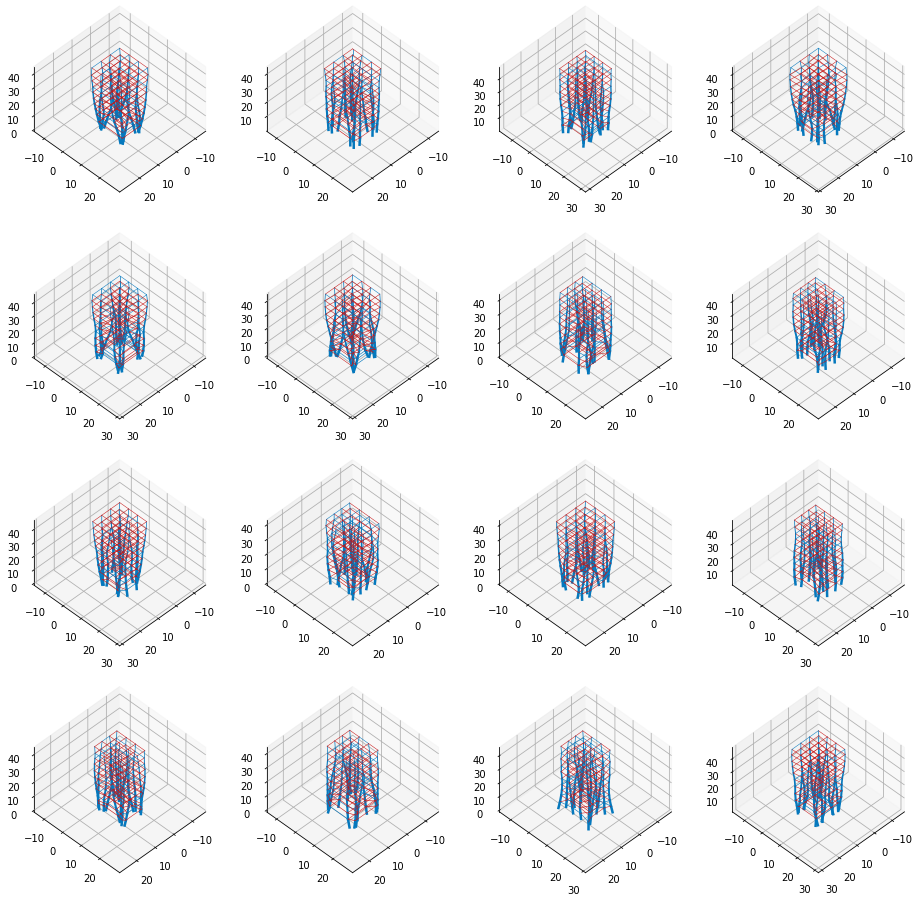

In [26]:
check_similar(0)

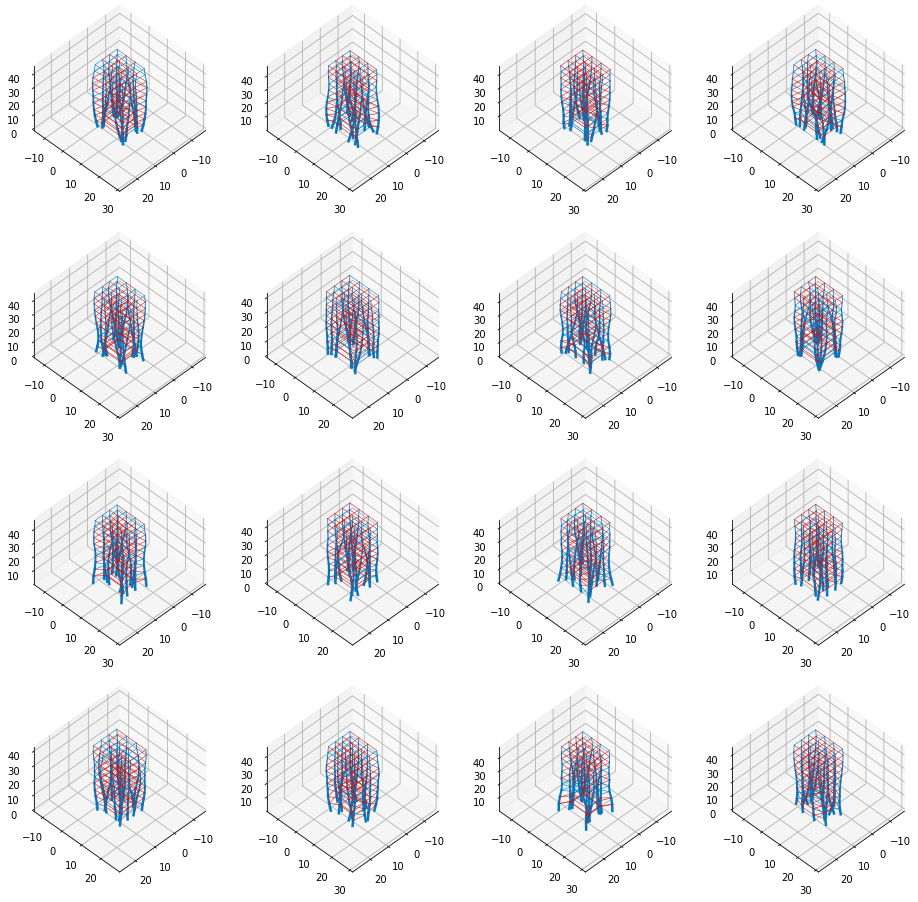

In [27]:
check_similar(400)

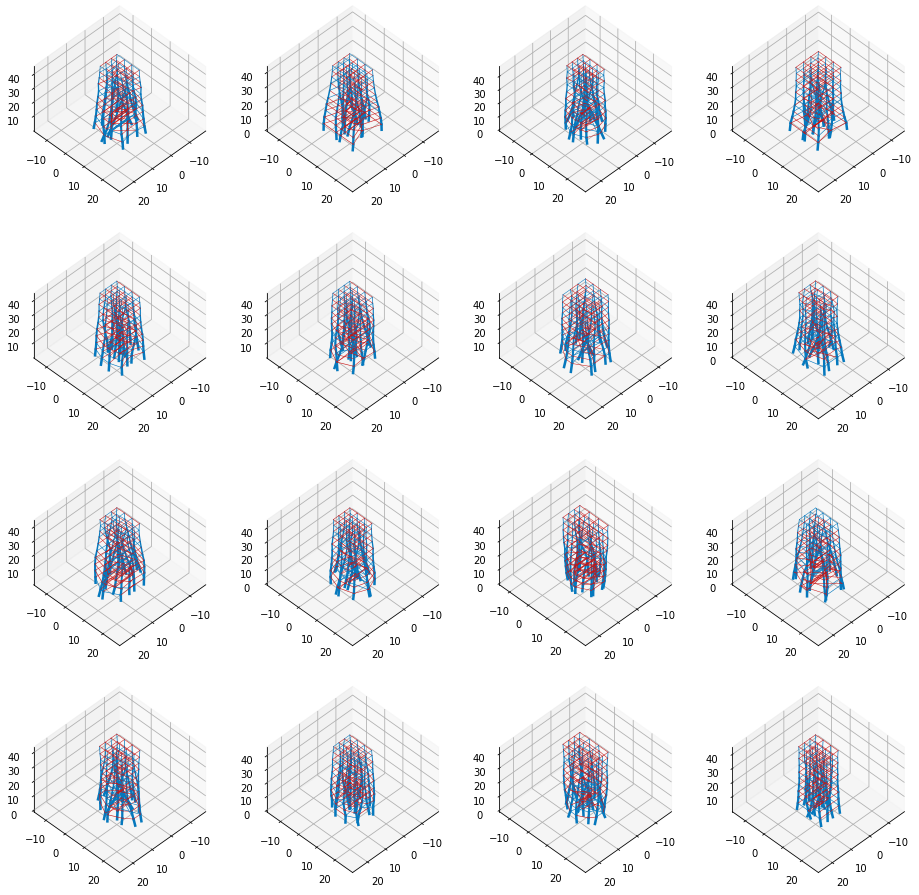

In [28]:
check_similar(35)

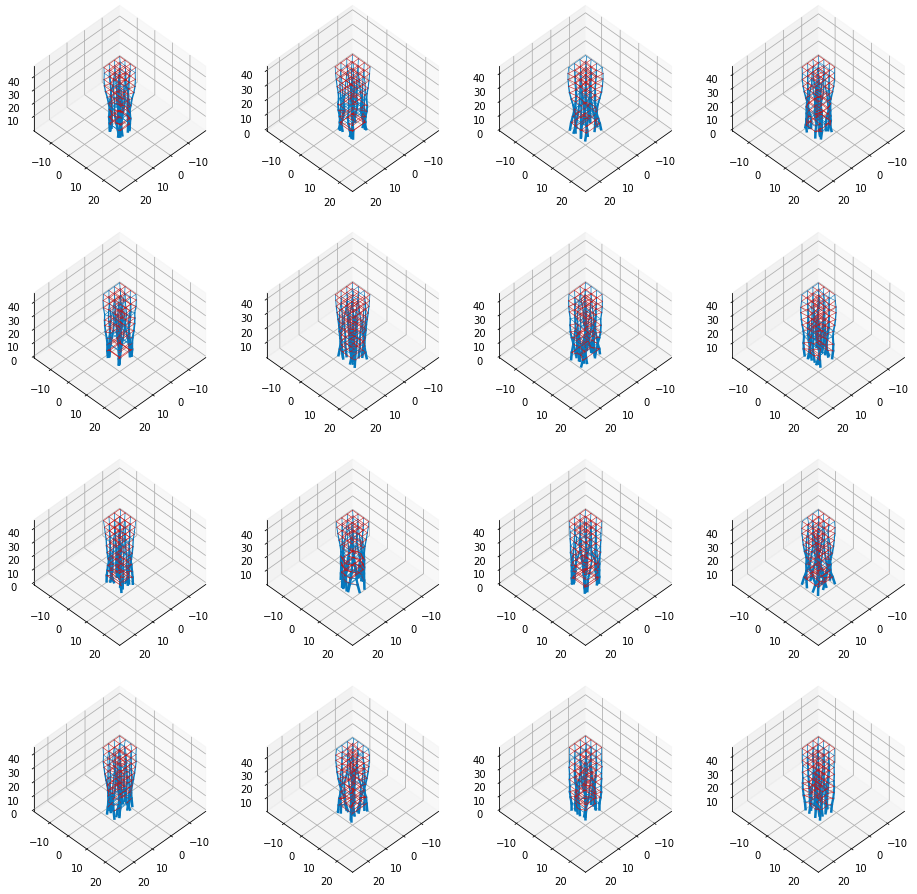

In [29]:
check_similar(15)

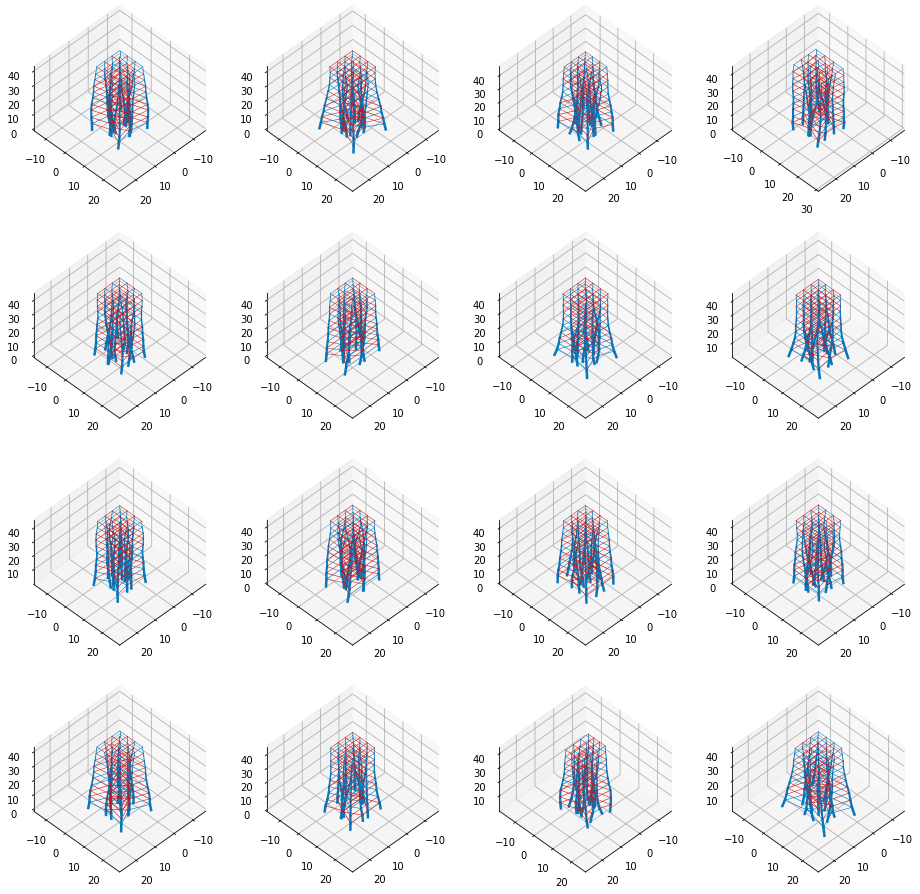

In [30]:
check_similar(3)

## train a som

In [22]:
mapsize = [20,20]
mapsize_str='x'.join([str(i) for i in mapsize])
mapsize_str

# mapsize = [12,12]
# mapsize_str='x'.join([str(i) for i in mapsize])
# mapsize_str

'40x40'

In [23]:
som = sompy.SOMFactory.build(training_vector_som,
                             mapsize,
                             mask=None,
                             mapshape='planar',
                             lattice='rect',
                             normalization='None', # use None for simplicity
                             initialization='pca',
                             neighborhood='gaussian',
                             training='batch',
                             name='sompy')

In [24]:
som.train(n_job=1,
          train_rough_len=60,
          train_rough_radiusin=15,
          train_rough_radiusfin=1,
          train_finetune_len=40,
          verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything

 Training...
 pca_linear_initialization took: 0.617000 seconds
 Rough training...
 radius_ini: 15.000000 , radius_final: 1.000000, trainlen: 60

 epoch: 1 ---> elapsed time:  4.134000, quantization error: 147.115747

 epoch: 2 ---> elapsed time:  4.198000, quantization error: 136.310286

 epoch: 3 ---> elapsed time:  4.151000, quantization error: 107.158709

 epoch: 4 ---> elapsed time:  4.421000, quantization error: 106.071305

 epoch: 5 ---> elapsed time:  4.445000, quantization error: 105.310954

 epoch: 6 ---> elapsed time:  4.387000, quantization error: 104.716217

 epoch: 7 ---> elapsed time:  4.412000, quantization error: 104.095982

 epoch: 8 ---> elapsed time:  4.304000, quantization error: 103.526652

 epoch: 9 ---> elapsed time:  4.409000, quantization error: 103.041593

 epoch: 10 ---> elapsed time:  4.296000, quantization error: 102.642616

 epoch: 11 ---> elapsed time:  4.445000, quantization error: 102.310425

 epoch: 12 ---> elapsed time:  4.355000, quantization error: 

In [25]:
som_util.save_som_to_file(os.path.join('../outputs/SOMs','som_%s_%s_%s.zip'%(mapsize_str,feature_code,cem_dataset.get_dataset_name())),som,False)

## load the SOM

In [14]:
mapsize = [20,20]
mapsize_str='x'.join([str(i) for i in mapsize])
mapsize_str

'20x20'

In [15]:
som = som_util.load_som_from_file(os.path.join('../outputs/SOMs','som_%s_%s_%s.zip'%(mapsize_str,feature_code,cem_dataset.get_dataset_name())))

dataraw is not given nor can be read from file, use random data instead (the bmu is not anymore valid)
wrapper normalizer is used, the normalization info will not changed by dataraw


## check cell

In [19]:
bmu,dist=som_util.find_bmus(som,training_vector_som)
bmu

array([132,  33,  18, ...,  23, 134,  26], dtype=int64)

In [32]:
which_cell=12*9+4
which_form=np.where(bmu==which_cell)[0]
which_form

array([  19,   71,  151,  232,  533,  554,  579,  635,  726,  784,  873,
        982, 1008, 1087, 1131, 1190, 1230, 1252, 1289, 1335, 1530, 1555,
       1657, 1695, 1738, 1856, 2217, 2226, 2318, 2362, 2363, 2407, 2457,
       2603, 2673, 2825, 2828, 2911, 2960, 2993, 3286, 3301, 3328, 3336,
       3370, 3390, 3707, 3880, 3936, 3993, 4179, 4183, 4383, 4403, 4420,
       4433, 4457, 4461], dtype=int64)

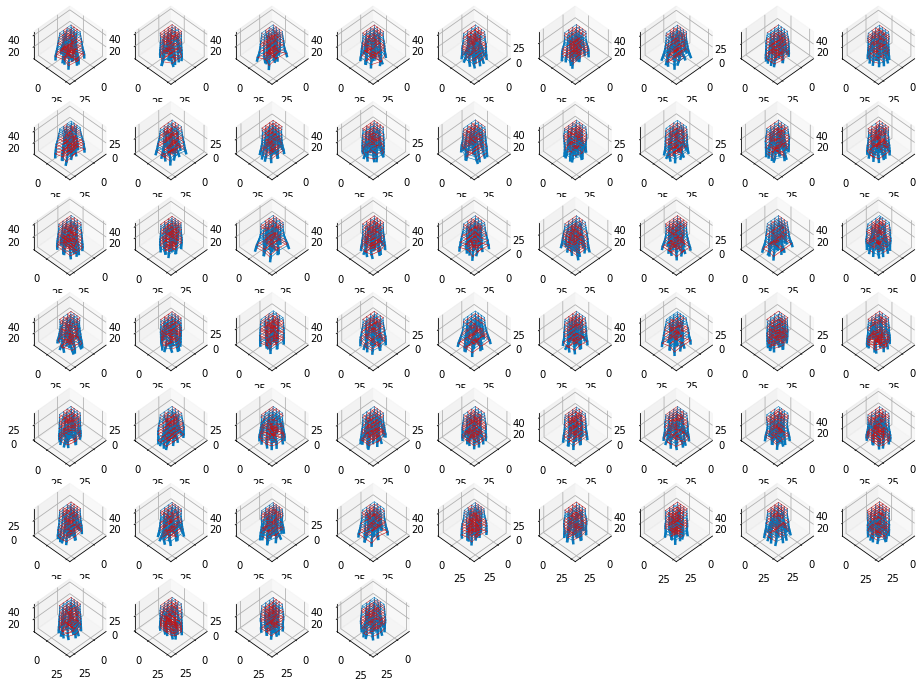

In [33]:
check_forms(cem_dataset.get_forms(which_form),'on')

## visualize the som

In [26]:
import io
import zipfile

In [27]:
bmu,dist=som_util.find_bmus(som,training_vector_som)
bmu

array([ 895, 1372,  796, ...,  383, 1448, 1262], dtype=int64)

render each cell

In [28]:
euclid_dist=[np.Inf]*(mapsize[0]*mapsize[1])
best_item=[-1]*(mapsize[0]*mapsize[1])

count=0
for i,d in zip(bmu,dist):
    if euclid_dist[i] >d:
        # the current image represent the bmu better
        euclid_dist[i]=d
        best_item[i]=count
    count+=1
len(best_item)

1600

In [29]:
# save renderings to a zip file
# use jpg to save space
with zipfile.ZipFile(os.path.join('../outputs/SOMs','som_%s_%s_%s_rendering.zip'%(mapsize_str,feature_code,cem_dataset.get_dataset_name())), 'w') as zf:
    for i in range(len(best_item)):
        print(i,end='\r')
        with io.BytesIO() as f_byte:
            check_forms(cem_dataset.get_forms(int(best_item[i])),'off','3D-45',fname=f_byte)
            zf.writestr('cell-%d.jpg'%i,f_byte.getvalue()) 

render the entire som

In [30]:
import cv2

In [31]:
cell_trim=400
cell_size=(512,512)

def read_bytes_from_zip(zf, name):
    with zf.open(name) as f:
        d=f.read()
    return d

with zipfile.ZipFile(os.path.join('../outputs/SOMs','som_%s_%s_%s_rendering.zip'%(mapsize_str,feature_code,cem_dataset.get_dataset_name()))) as zf:
    cells=[cv2.imdecode(np.frombuffer(read_bytes_from_zip(zf, 'cell-%d.jpg'%i),dtype=np.uint8), cv2.IMREAD_COLOR) for i in range(len(best_item))]

# cells=[cv2.imread('../temp/%d.png'%i) for i in range(400)]
cell_trim=([c[cell_trim:-cell_trim,cell_trim:-cell_trim] for c in cells] if cell_size is None else [cv2.resize(c[cell_trim:-cell_trim,cell_trim:-cell_trim],cell_size) for c in cells])

In [32]:
rows=[np.concatenate(cell_trim[i*mapsize[1]:i*mapsize[1]+mapsize[1]],axis=1) for i in range(mapsize[0])]
render=np.concatenate(rows,axis=0)

In [33]:
cv2.imwrite('../outputs/SOMs/som_%s_%s_%s.jpg'%(mapsize_str,feature_code,cem_dataset.get_dataset_name()),render)

True